In [1]:
import pandas as pd
import numpy as np

In [2]:
paywallDateCols = ['Registration Date','(Pw) Analytics','(Pw) Backup-restore',
                   '(Pw) Color-Management','(Pw) Custom-Fonts','(Pw) Downloadable-Publication',
                   '(Pw) Email-Thumb','(Pw) Embedding','(Pw) Page-Limit','(Pw) Pdf-dpi',
                   '(Pw) Premium Templates','(Pw) Pub-Password','(Pw) Publish-banner',
            '(Pw) Revision-history','(Pw) Storage','(Pw) Unlicensed/View Only']

pw_df = pd.read_csv(
    'paywall_data.csv',
    index_col='id',
    parse_dates=paywallDateCols
)
paymentDateCols = ['First Payment Date']
pwp_df = pd.read_csv(
    'paywall_payment_data.csv',
    index_col='id',
    parse_dates=paymentDateCols
)

## Counting up the number of times each paywall was hit

For users that paid we need only to count paywalls that were hit up to the date that they paid. We will not consider paywalls hit after that date.

In [3]:
# counting up the number of times each paywall was hit
usersWhoPaid = pw_df[pw_df['Paid?']>0].join(pwp_df, how='inner')
justPaywallCols = usersWhoPaid[paywallDateCols[1:] + paymentDateCols]
paywallCountForPaid = justPaywallCols \
    .apply(lambda x: x <= justPaywallCols['First Payment Date']) \
    .drop('First Payment Date', axis=1).sum()


For users that have not paid we count all paywalls they have seen.

In [4]:
usersWhoNoPay = pw_df[pw_df['Paid?']==0][paywallDateCols[1:]]
paywallCountForNotPaid = usersWhoNoPay.apply(pd.notnull).sum()

In [5]:
totalPaywallCount = paywallCountForPaid + paywallCountForNotPaid

## Counting up the number of times each paywall converted

We will consider the paywall date closest to the paid date to be the paywall that caused the conversion

In [20]:
closestPayWalls = justPaywallCols \
    .apply(lambda x: x - justPaywallCols['First Payment Date']) \
    .applymap(lambda x: x if x.total_seconds() < 0 else float('nan')) \
    .drop('First Payment Date', axis=1).idxmax(axis=1)



paywallConverters = closestPayWalls.value_counts()
paywallConverters

(Pw) Page-Limit                  341
(Pw) Pdf-dpi                     286
(Pw) Storage                     174
(Pw) Color-Management             90
(Pw) Custom-Fonts                 75
(Pw) Downloadable-Publication     47
(Pw) Premium Templates            44
(Pw) Email-Thumb                  42
(Pw) Analytics                    18
(Pw) Publish-banner               15
(Pw) Embedding                     9
(Pw) Backup-restore                7
(Pw) Pub-Password                  3
(Pw) Unlicensed/View Only          3
(Pw) Revision-history              3
dtype: int64

## Finding Conversion Rates

Now that we have the total paywall counts and paywall conversion counts we can find the paywall converstion rates.

In [21]:
conversionRates = (paywallConverters / totalPaywallCount) \
    .sort_values(ascending=False)

In [22]:
conversionRates

(Pw) Backup-restore              0.118644
(Pw) Page-Limit                  0.098271
(Pw) Analytics                   0.088670
(Pw) Pdf-dpi                     0.067501
(Pw) Storage                     0.066795
(Pw) Embedding                   0.060000
(Pw) Custom-Fonts                0.043054
(Pw) Email-Thumb                 0.037070
(Pw) Color-Management            0.037007
(Pw) Downloadable-Publication    0.036547
(Pw) Unlicensed/View Only        0.024390
(Pw) Revision-history            0.021277
(Pw) Publish-banner              0.020921
(Pw) Premium Templates           0.013002
(Pw) Pub-Password                0.011194
dtype: float64

Text(0,0.5,'Conversion Rate')

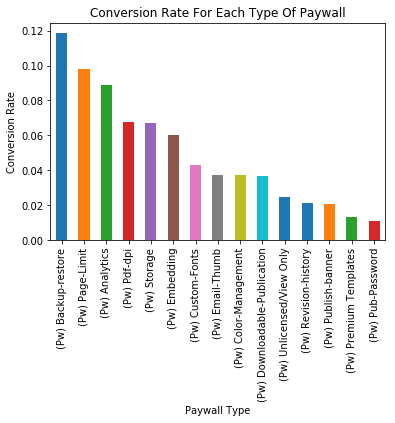

In [23]:
conversionRatePlot = conversionRates \
    .plot(kind='bar', title='Conversion Rate For Each Type Of Paywall')

conversionRatePlot.set_xlabel('Paywall Type')
conversionRatePlot.set_ylabel('Conversion Rate')

## Attributing Revenue To Paywalls

To find out which paywalls contribute most to revenue, we will find the total sum of first payments attributed to each paywall as well as the average first payment attributed to each paywall

In [10]:
payWallAndPaymentValue = closestPayWalls.to_frame() \
   .join(usersWhoPaid) \
    .rename(columns={0:'paywallType'})[['paywallType', 'First Payment Value']]

Text(0,0.5,'Average Payment in $')

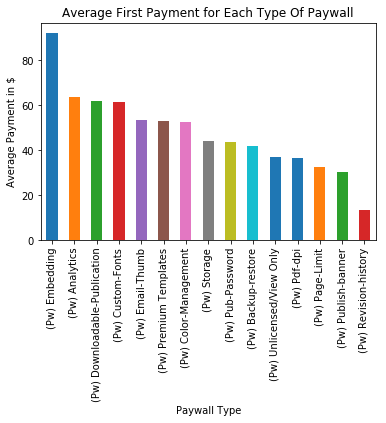

In [11]:
sortedAvgPayments = payWallAndPaymentValue.groupby('paywallType') \
    .mean() \
    .sort_values('First Payment Value', ascending=False)

avgPaymentSeries = pd.Series(
    sortedAvgPayments['First Payment Value'],
    sortedAvgPayments.index
)
avgPaymentPlot = avgPaymentSeries.plot(
    kind='bar',
    title='Average First Payment for Each Type Of Paywall'
)
avgPaymentPlot.set_xlabel('Paywall Type')
avgPaymentPlot.set_ylabel('Average Payment in $')

Text(0,0.5,'Sum Total Payment in $')

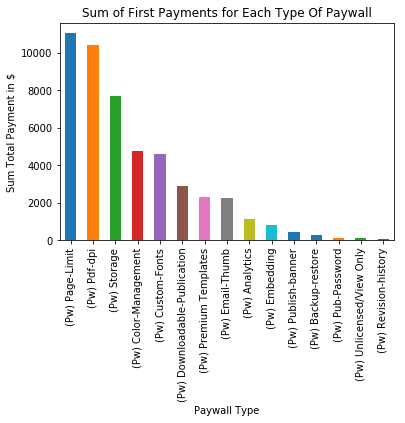

In [12]:
sortedSumPayments = payWallAndPaymentValue \
.groupby('paywallType') \
.sum() \
 .sort_values('First Payment Value', ascending=False)

sumPaymentSeries = pd.Series(
    sortedSumPayments['First Payment Value'],
    sortedSumPayments.index
)
sumPaymentPlot = sumPaymentSeries.plot(
    kind='bar',
    title='Sum of First Payments for Each Type Of Paywall'
)
sumPaymentPlot.set_xlabel('Paywall Type')
sumPaymentPlot.set_ylabel('Sum Total Payment in $')